In [1]:
#Final yes

#modules
    #Untuk modelling
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
import keras_tuner as kt

    #basic statiscal modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

    #necessities 
import os
from tqdm.notebook import tqdm
import datetime

    #Untuk metriks
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
import haha

#random seed sehingga seed modelling pada module tensorflow dapat direplikasi
tf.random.set_seed(7)
log_dir = "../../assets/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

Using TensorFlow backend


In [2]:
#load dataset
df=pd.read_csv("../../Data/Harian/Rata Harian.csv").iloc[:,2]

#get data from 15 latest months
df=df[-(30*15):]

In [3]:
#Rescale the data to the range of 0-to-1
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df.values.reshape(-1,1))
df=scaler.transform(df.values.reshape(-1,1))

In [4]:
#train test split; train 12 months, 3 months for testing
train=df[:30*12]; test=df[30*12:]

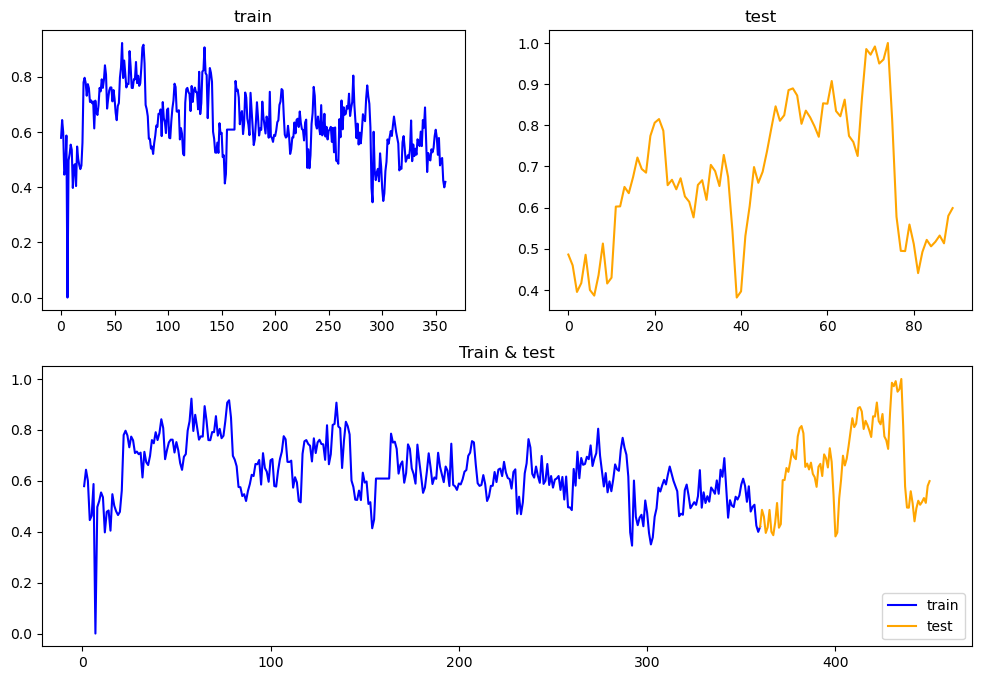

In [5]:
haha.plottraintest(train, test)

In [6]:
# reshape into X=t and Y=t+1
t=30
trainX, trainY = haha.lag(train,t)
testX, testY = haha.lag(test,t)

In [7]:
#ubah data sehingga kompatibel dengan shape input model
# reshape input to be [samples, features, time steps]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [8]:
batch_size=32

#create model
def getmodel_compile():
    model=keras.Sequential([
        
        keras.layers.LSTM(4, input_shape=(t, 1), return_sequences=True),                   #input and 1st layer
        keras.layers.LSTM(8),                                                              #2nd layer
        keras.layers.Dense(1)])                                                                                             #output (pakai 1 karena output berbentuk regresi)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.MeanAbsolutePercentageError()])
    return model

In [11]:
model=getmodel_compile()

thehistory=model.fit(trainX, trainY, epochs=1000, 
                     batch_size=batch_size)

Epoch 1/1000
11/11 [==============================] - 4s 14ms/step - loss: 0.1584 - mean_absolute_error: 0.3813 - mean_absolute_percentage_error: 59.0181
Epoch 2/1000
11/11 [==============================] - 0s 13ms/step - loss: 0.0346 - mean_absolute_error: 0.1582 - mean_absolute_percentage_error: 23.5802
Epoch 3/1000
11/11 [==============================] - 0s 16ms/step - loss: 0.0105 - mean_absolute_error: 0.0820 - mean_absolute_percentage_error: 14.1389
Epoch 4/1000
11/11 [==============================] - 0s 14ms/step - loss: 0.0126 - mean_absolute_error: 0.0910 - mean_absolute_percentage_error: 16.1452
Epoch 5/1000
11/11 [==============================] - 0s 16ms/step - loss: 0.0093 - mean_absolute_error: 0.0772 - mean_absolute_percentage_error: 12.8072
Epoch 6/1000
11/11 [==============================] - 0s 19ms/step - loss: 0.0092 - mean_absolute_error: 0.0760 - mean_absolute_percentage_error: 12.1748
Epoch 7/1000
11/11 [==============================] - 0s 14ms/step - loss: 0

In [12]:
#predict
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)

2/2 [==============================] - 0s 6ms/step


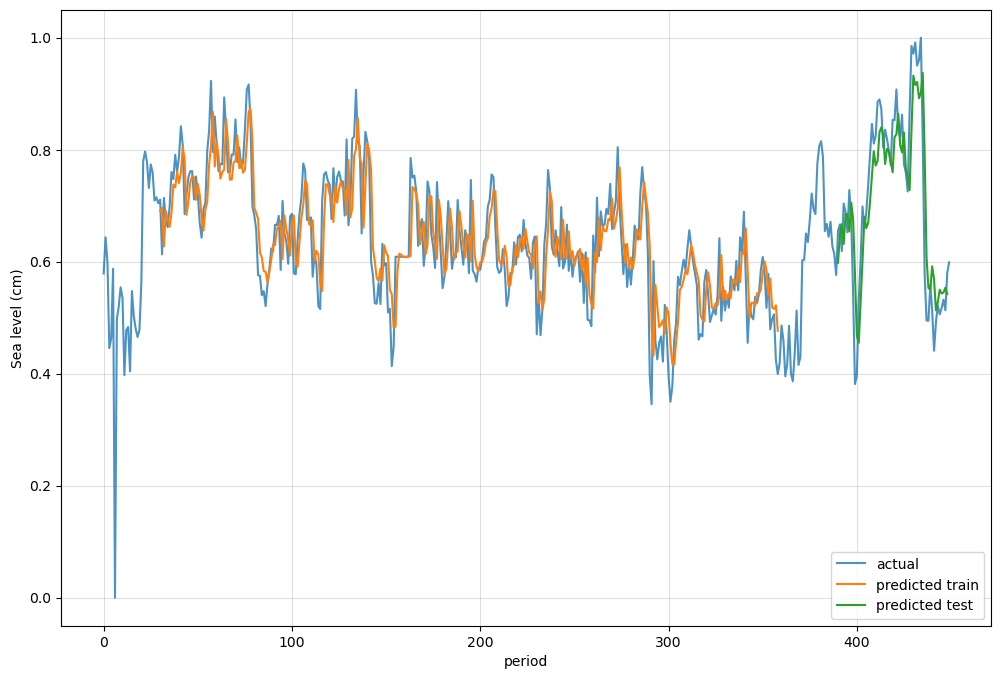

In [14]:
haha.plot_predicted(df, trainPredict.reshape(-1,1), testPredict.reshape(-1,1), t)

In [15]:
def forecast(predictedday, model, testdata, t):
    forecasted=[]
    theinput=testdata[-t:]

    firstinput = theinput.reshape((1, t,1))
    temppredicted = model.predict(firstinput, verbose=0)
    theinput=np.concatenate((theinput, temppredicted), axis=0)
    forecasted.append(scaler.inverse_transform(temppredicted.reshape(1,-1))[0])
    
    for i in range(1,predictedday):
        theinput=theinput[1:].flatten().reshape(1,t,1)
        temppredicted=model.predict(theinput, verbose=0)
        theinput=np.concatenate((theinput.reshape(-1,1), temppredicted), axis=0)
        forecasted.append(scaler.inverse_transform(temppredicted.reshape(1,-1))[0])
        
    return np.array(forecasted)

iwannaforecast=90
z=forecast(predictedday=iwannaforecast, model=model, testdata=train, t=t)

In [16]:
z

array([[175.49901],
       [176.90132],
       [178.11269],
       [179.07587],
       [179.80891],
       [180.36116],
       [180.77989],
       [181.10481],
       [181.36784],
       [181.58745],
       [181.7914 ],
       [181.9597 ],
       [182.1254 ],
       [182.32803],
       [182.52237],
       [182.71843],
       [182.91188],
       [183.09763],
       [183.28084],
       [183.43887],
       [183.58109],
       [183.71887],
       [183.86398],
       [183.9956 ],
       [184.13115],
       [184.271  ],
       [184.4239 ],
       [184.57796],
       [184.75026],
       [184.9222 ],
       [185.11288],
       [185.30344],
       [185.49577],
       [185.65735],
       [185.83324],
       [185.99098],
       [186.13994],
       [186.2929 ],
       [186.44563],
       [186.59744],
       [186.74673],
       [186.89711],
       [187.04361],
       [187.16722],
       [187.30779],
       [187.42892],
       [187.54553],
       [187.66399],
       [187.7772 ],
       [187.89262],


Text(0.5, 0, 'Period')

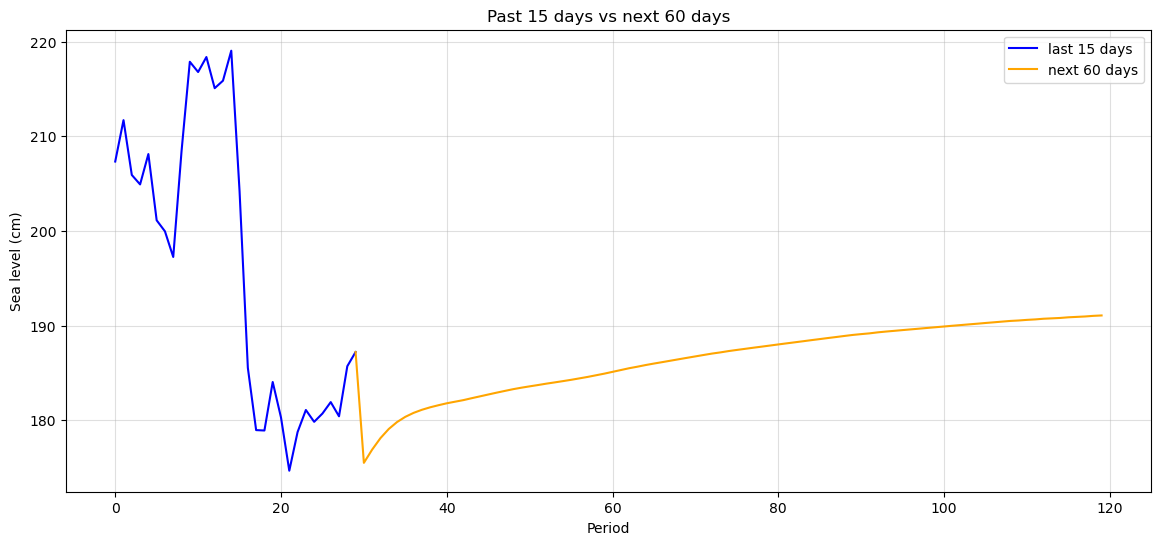

In [17]:
temp=np.array([None for i in range(t+iwannaforecast)])
temp[t-1]=scaler.inverse_transform(test)[len(test)-1][0]
temp[t:]=z.flatten()

fig, ax = plt.subplots(1,1, figsize=(14,6))
ax.plot(scaler.inverse_transform(test[-t:]), c="blue", label="last 15 days")
ax.plot(temp, c="orange", label="next 60 days")
ax.grid(alpha=0.4)
ax.set_title("Past 15 days vs next 60 days")
ax.legend(loc="upper right")
ax.set_ylabel("Sea level (cm)")
ax.set_xlabel("Period")

In [24]:
z

array([[175.49901],
       [176.90132],
       [178.11269],
       [179.07587],
       [179.80891],
       [180.36116],
       [180.77989],
       [181.10481],
       [181.36784],
       [181.58745],
       [181.7914 ],
       [181.9597 ],
       [182.1254 ],
       [182.32803],
       [182.52237],
       [182.71843],
       [182.91188],
       [183.09763],
       [183.28084],
       [183.43887],
       [183.58109],
       [183.71887],
       [183.86398],
       [183.9956 ],
       [184.13115],
       [184.271  ],
       [184.4239 ],
       [184.57796],
       [184.75026],
       [184.9222 ],
       [185.11288],
       [185.30344],
       [185.49577],
       [185.65735],
       [185.83324],
       [185.99098],
       [186.13994],
       [186.2929 ],
       [186.44563],
       [186.59744],
       [186.74673],
       [186.89711],
       [187.04361],
       [187.16722],
       [187.30779],
       [187.42892],
       [187.54553],
       [187.66399],
       [187.7772 ],
       [187.89262],


Text(0.5, 0, 'Period')

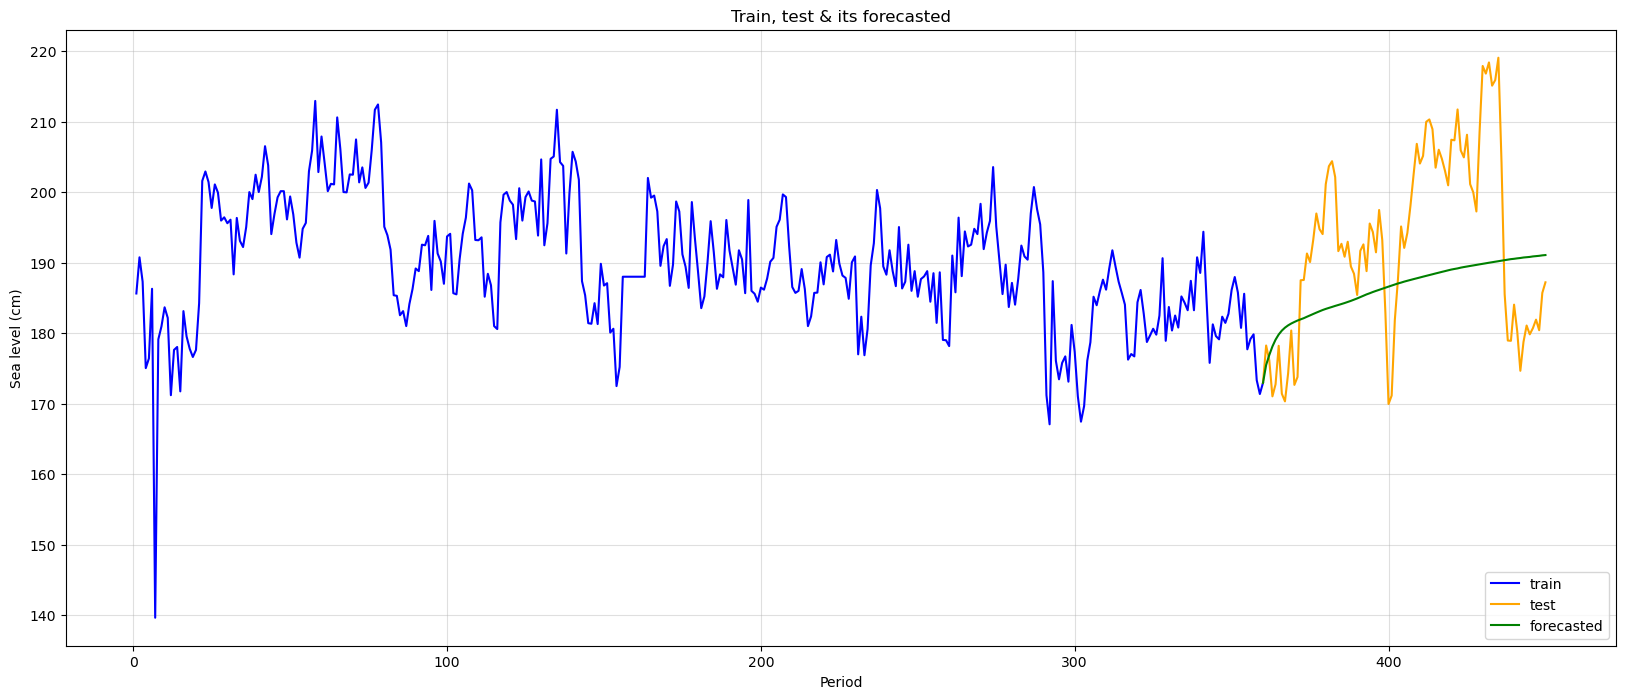

In [45]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
temp=np.array(list(map(list, zip(train.flatten(), range(1,len(train)+1)))))
ax.plot(temp[:,1], scaler.inverse_transform(temp[:,0].reshape(-1, 1)), c="blue", label="train")

temp=np.array(list(map(list, zip(test.flatten(), range(len(train)+1,len(train)+len(test)+1)))))
temp=np.concatenate(([[train.flatten()[-1],len(train)]], temp),axis=0)

ax.plot(temp[:,1], scaler.inverse_transform(temp[:,0].reshape(-1, 1)), c="orange", label="test")

temp=np.array(list(map(list, zip(z.flatten(), range(len(train)+1,len(train)+len(z)+1)))))
temp=np.concatenate(([[scaler.inverse_transform(train.flatten()[-1].reshape(1,-1))[0][0],len(train)]], temp),axis=0)
ax.plot(temp[:,1], temp[:,0], c="green", label="forecasted")

ax.legend(loc="lower right")
ax.set_title("Train, test & its forecasted")
ax.grid(alpha=0.4)
ax.set_ylabel("Sea level (cm)")
ax.set_xlabel("Period")

In [43]:
scaler.inverse_transform(train.flatten()[-1].reshape(1,-1))[0][0]

172.95833333333334

In [46]:
#idk!11
test=scaler.inverse_transform(test)

def aic(y, y_pred, k=2):
   return len(y)*math.log(mean_squared_error(y,y_pred))+2*k

def bic(y, y_pred, k=2):
   return len(y)*math.log(mean_squared_error(y,y_pred))+k*math.log(len(y))

def residual(y, y_pred):
   return y-y_pred

def msd(y, y_pred):
   resid=residual(y, y_pred)
   return np.mean(resid*resid)

def mad(y, y_pred):
   resid=residual(y, y_pred)
   return np.mean(abs(resid))

themetrics=pd.DataFrame([
    mean_absolute_error(test, z),
    mean_squared_error(test, z),
    math.sqrt(mean_squared_error(test, z)),
    mean_absolute_percentage_error(test, z),
    aic(test,z),
    bic(test, z),
    msd(test, z),
    mad(test, z)
    ],index=[ "MAE", "MSE", "RMSE", "MAPE", "aic", "bic", "msd", "mad"])

test=scaler.transform(test)

print("Metrics forecasted and actual test")
themetrics

Metrics forecasted and actual test


,0
MAE,11.759866
MSE,185.034784
RMSE,13.602749
MAPE,0.059517
aic,473.848945
bic,478.848564
msd,185.034784
mad,11.759866
